У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.
Данные
В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:
●	data_train.csv: id, vas_id, buy_time, target
●	features.csv.zip: id, <feature_list> 

И тестовый набор:
●	data_test.csv: id, vas_id, buy_time
target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.
Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).
 sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation





Формат представления результата
1.	Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
2.	Код модели можно представить в виде jupyter-ноутбука. 
3.	Презентация в формате .pdf, в которой необходимо отразить:
●	Информация о модели, ее параметрах, особенностях и основных результатах.
●	Обоснование выбора модели и ее сравнение с альтернативами.
●	Принцип составления индивидуальных предложений для выбранных абонентов.
Рекомендуемое количество слайдов – 5 – 10.
Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.


In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib2 import Path
import sys
from datetime import date
import itertools
import logging
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn import set_config
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [2]:
RANDOM_STATE = 42

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of the dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

sys.modules[__name__] = reduce_mem_usage

Пути к данным

In [4]:
TRAIN_DATASET_PATH = r'D:\megafon_project\data_train.csv'
TEST_DATASET_PATH = r'D:\megafon_project\data_test.csv'
FEATURES_PATH = r'D:\megafon_project\features.csv'

Загрузим и посмотрим данные

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
features_df = dd.read_csv(FEATURES_PATH, sep='\t')
answers_test = test_df


In [6]:
train_df.tail(5)

,Unnamed: 0,id,vas_id,buy_time,target
831648,831648,3812226,2.0,1546203600,0.0
831649,831649,2480469,2.0,1546203600,0.0
831650,831650,158236,2.0,1546203600,0.0
831651,831651,1825525,2.0,1546203600,0.0
831652,831652,3022610,2.0,1546203600,0.0


In [7]:
test_df.head(5)

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [8]:
features_df.head(5)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


Обзор данных

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB


In [10]:
reduce_mem_usage(train_df)

Memory usage of the dataframe is 31.73 MB
Memory usage after optimization is: 15.86 MB
Decreased by 50.0%


,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0
...,...,...,...,...,...
831648,831648,3812226,2.0,1546203600,0.0
831649,831649,2480469,2.0,1546203600,0.0
831650,831650,158236,2.0,1546203600,0.0
831651,831651,1825525,2.0,1546203600,0.0


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB


In [12]:
reduce_mem_usage(test_df)

Memory usage of the dataframe is 2.17 MB
Memory usage after optimization is: 1.09 MB
Decreased by 50.0%


,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400
...,...,...,...,...
71226,71226,2502453,5.0,1548018000
71227,71227,1693213,2.0,1548018000
71228,71228,1891350,2.0,1548018000
71229,71229,2437172,2.0,1548018000


Text(0.5, 1.0, 'Распределение подключения услуги на train')

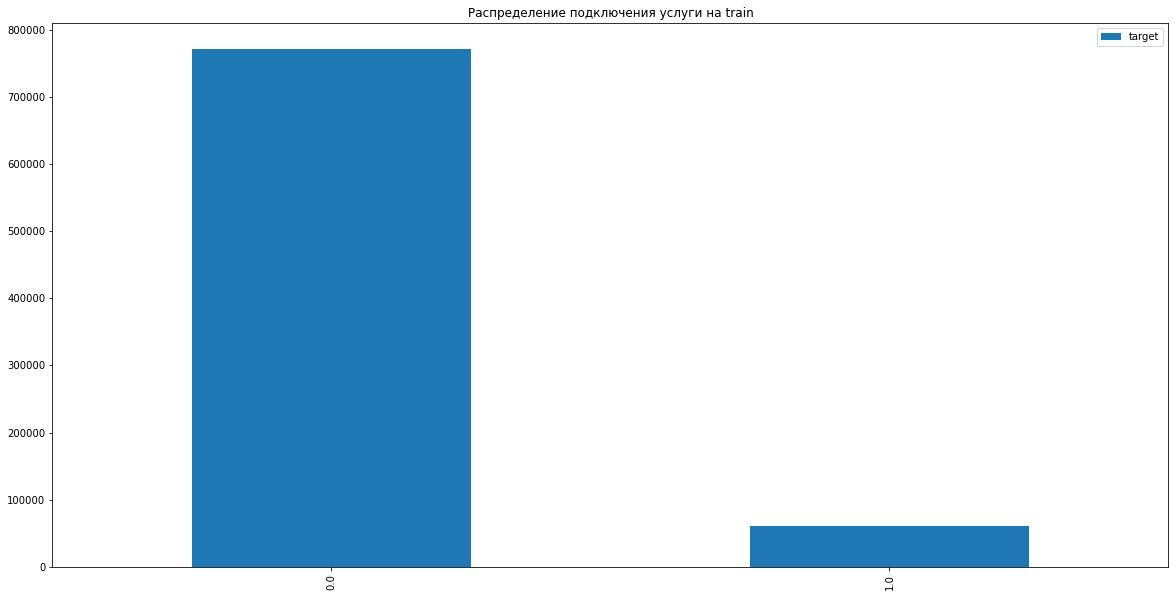

In [13]:
plt.figure(figsize=(20, 10))
train_df['target'].value_counts().plot(kind='bar', label='target')
plt.legend()
plt.title('Распределение подключения услуги на train')

Присутствует дисбаланс классов

In [14]:
train_df['time'] = train_df.apply(lambda x: pd.Timestamp.fromtimestamp(x['buy_time']), axis=1)

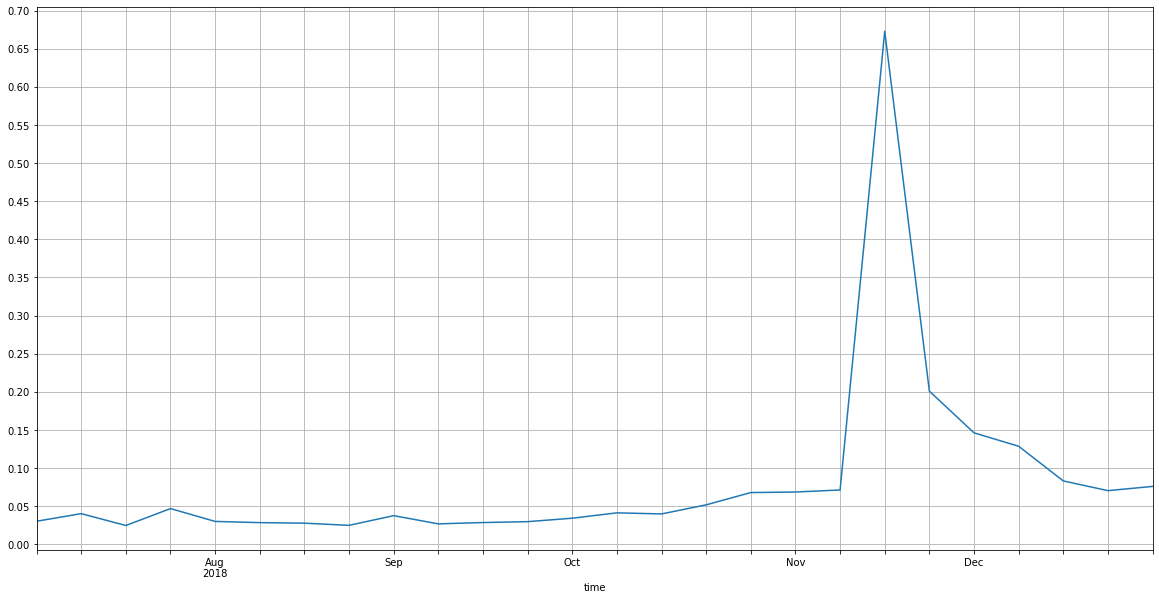

In [15]:
plt.figure(figsize=(20, 10))
train_df.groupby(['time'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(train_df['time'].unique())
plt.yticks(np.arange(0, 0.71, 0.05))
plt.grid()


plt.show()

Видим всплеск в ноябре, создадим маску, что бы исключить эти данные

In [16]:
mask = train_df['buy_time'] == '2018-11-19'

In [17]:
del train_df['time']

Посмотрим на подключение услуг

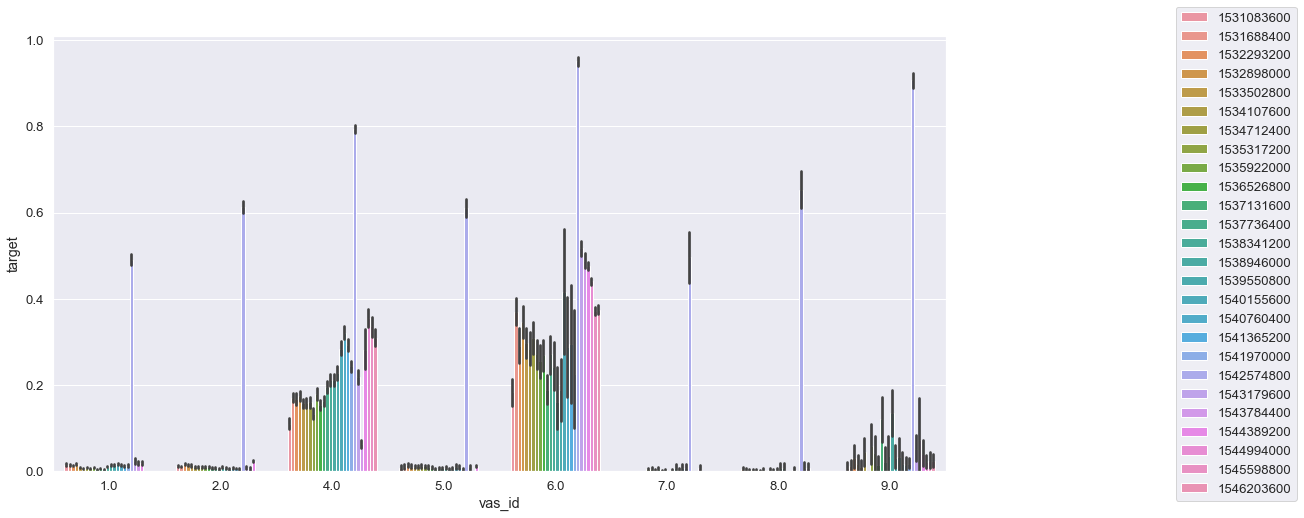

In [18]:
sns.set(font_scale=1.2)
plt.figure(figsize=(16, 8))
g = sns.barplot(x = 'vas_id',
            y = 'target',
            hue='buy_time',
            data = train_df)#[~mask])
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

Чаще всего подключают 4 и 6 услуги

In [19]:
def process_featues(features_df, train_df, test_df):
    ids = np.unique(train_df['id'].append(test_df['id']))
    # Возьмем id только тех пользователей, что встречаются в трейн и тест выборках.
    features_df = features_df[features_df['id'].isin(ids)]
    # Дропнем Unnamed
    if 'Unnamed: 0' in features_df:
        features_df = features_df.drop(columns='Unnamed: 0')

    features_df = features_df.compute()
    # удалим признаки с единственным значением
    df_nunique = features_df.apply(lambda x: x.nunique(dropna=False))
    const = df_nunique[df_nunique ==1].index.tolist()
    features_df = features_df.drop(columns = const)
    features_df = reduce_mem_usage(features_df)
    return features_df

In [20]:
features_df = process_featues(features_df, train_df, test_df)

Memory usage of the dataframe is 1728.06 MB
Memory usage after optimization is: 867.47 MB
Decreased by 49.8%


In [21]:
features_df.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
13,2046132,1534712400,300.820038,1599.480835,286.879211,1585.013184,281.461761,1563.908203,-16.08618,654.013916,...,-977.37384,-613.770813,-25.996269,-35.625,-295.747711,-17.832888,-0.694336,-4.175933,-0.456055,0.0
16,2050810,1540760400,-86.209969,91.820885,-84.480789,110.333199,-89.898247,89.228210,-16.08618,-65.076096,...,-977.37384,-613.770813,-23.996269,190.375,-286.747711,-25.832888,-0.694336,-12.175933,-0.456055,0.0
19,2070757,1540760400,-96.799973,-408.179108,-110.740784,-460.786804,-114.038246,-479.771790,-16.08618,-65.076096,...,-925.37384,-561.770813,-21.996269,-37.625,-151.747726,-24.832888,0.305664,-12.175933,-0.456055,1.0
20,2071522,1544994000,-94.939972,-363.699127,-108.880783,-411.226807,-114.298248,-432.331787,-16.08618,-65.076096,...,-977.37384,-613.770813,-25.996269,-37.625,-306.747711,-25.832888,-0.694336,-12.175933,-0.456055,0.0
22,2075318,1533502800,-75.639969,669.690918,-89.580788,732.343201,-94.998245,736.658203,-16.08618,782.383911,...,-501.37384,-242.770798,-25.996269,-37.625,-167.747726,-14.832889,2.304688,-4.175933,-0.456055,0.0


Построим тепловую карту

<AxesSubplot:>

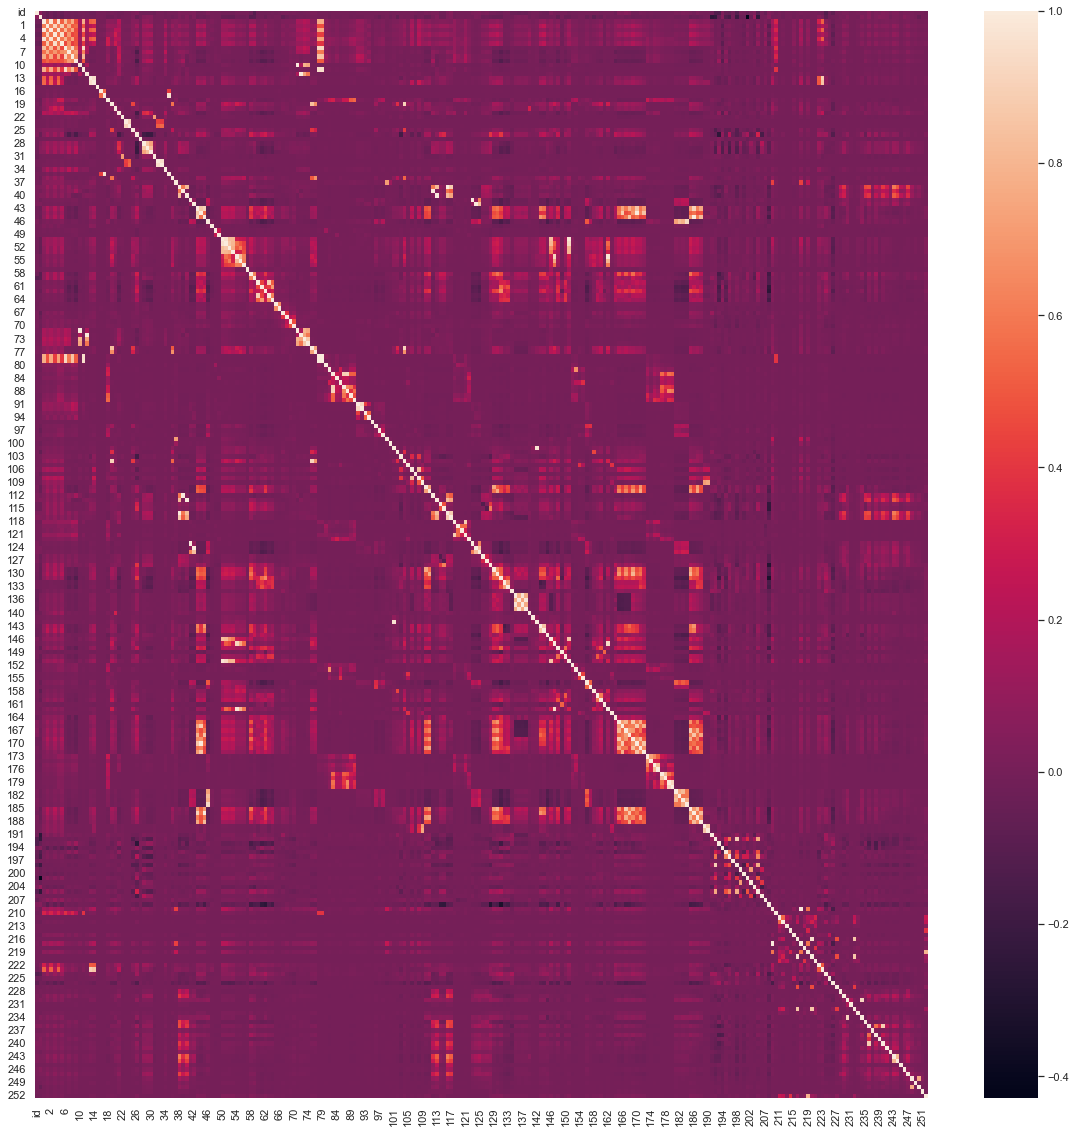

In [22]:
sns.set(rc={'figure.figsize':(20, 20)})
sns.heatmap(features_df.corr())

По тепловой карте видно, что есть группы признаков с высокой корреляцией. Необходимо использовать регуляризацию.

In [23]:
train_df = train_df.sort_values(by="buy_time")
test_df = test_df.sort_values(by="buy_time")
features_df = features_df.sort_values(by="buy_time")

In [24]:
train = pd.merge_asof(train_df, features_df, on='buy_time', by='id', direction='nearest')
valid = pd.merge_asof(test_df, features_df, on='buy_time', by='id', direction ='nearest')

In [25]:
del train['Unnamed: 0']
del valid['Unnamed: 0']

Разделим данные на X и y

In [26]:
X_train = train.drop('target', axis='columns')
y_train = train.target
X_valid = valid

In [27]:
train.head(3)

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2582523,2.0,1531083600,0.0,314.560028,9.290888,342.989227,7.523202,337.571747,-13.581790,...,6488.625977,-574.770813,-24.996269,121.375,142.252274,-16.832888,-0.694336,-11.175933,-0.456055,0.0
1,1292549,2.0,1531083600,0.0,93.880028,-217.499115,79.939217,-270.106812,74.521751,-291.211792,...,-977.373840,-613.770813,-25.996269,-37.625,-306.747711,-25.832888,-0.694336,-12.175933,-0.456055,0.0
2,4053116,1.0,1531083600,0.0,125.110031,152.190887,111.169212,107.213203,105.751755,86.108208,...,-956.373840,-613.770813,-18.996269,761.500,-213.747726,26.167112,-0.694336,39.824066,-0.456055,1.0


In [28]:
valid.head(3)

,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,2905850,5.0,1546808400,326.930023,227.410889,312.989227,200.223206,307.571747,179.118210,-16.08618,...,-464.37384,-104.770790,-25.996269,-18.625,-209.747726,-15.832889,-0.694336,-2.175933,-0.456055,0.0
1,31619,2.0,1546808400,-96.799973,100.290886,-62.040787,250.953201,-67.458244,229.848206,-16.08618,...,-977.37384,-613.770813,-25.996269,-37.625,-306.747711,-25.832888,-0.694336,-12.175933,-0.456055,0.0
2,1427271,6.0,1546808400,-87.299973,-368.999115,339.439209,48.733200,334.021759,27.628210,-16.08618,...,928.62616,-548.770813,0.003731,-37.625,116.252274,25.167112,-0.694336,38.824066,-0.456055,0.0


In [30]:
features = [f for f in valid.columns if f not in ['id']]

Разделим признаки на бинарные, категориальные и вещественные.

In [31]:
boolean_features = []
categorical_features = []
numeric_features = []
for col in X_train[features].fillna(0):
    val_count = len(X_train[col].unique())
    if val_count == 2:
        boolean_features.append(col)
    elif val_count <= 10:
        categorical_features.append(col)
    else:
        numeric_features.append(col)

In [32]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [33]:
# new_features_list = ['interval']
class FeaturesGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, features_list):
        self.features_list = features_list

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        assert isinstance(X, pd.DataFrame)

        try:
#             if 'interval' in self.features_list:
#                 X['interval'] = X['buy_time_y'] - X['buy_time_x']
            

            return X
        except KeyError:            
            raise KeyError("DataFrame не содердит колонки buy_time")

Соберем пайплайн

In [34]:
# Обработка вещественных признаков
num_pipe = Pipeline([
    ('ncs', ColumnSelector(columns=numeric_features)),
    ('nsi', SimpleImputer(strategy="mean")),
    ('nss', StandardScaler()),
    ('nskb', SelectKBest(k=128, score_func=f_classif)),
])

In [35]:
# Обработка категориальных признаков
cat_pipe = Pipeline([
    ('ccs', ColumnSelector(columns=categorical_features)),
    ('csi', SimpleImputer(strategy="most_frequent")),
    ('coe', OneHotEncoder(handle_unknown='ignore')),
])

In [36]:
#Обработка булевых признаков
bool_pipe = Pipeline([
    ('bcs', ColumnSelector(columns=boolean_features)),
    ('bsi', SimpleImputer(strategy="most_frequent")),
])

In [37]:
# Общий пайплайн

transformer_list = [('num_pipe', num_pipe), ('cat_pipe', cat_pipe), ('bool_pipe', bool_pipe)]

In [38]:
transform_pipe = Pipeline([
    ('cs', ColumnSelector(columns=features)),
    ('fg', FeaturesGenerator(features_list=['interval'])),
    ('fu', FeatureUnion(transformer_list=transformer_list)),
])

Отберем признаки с помощью SelectKBest

In [39]:
fs_pipe = make_pipeline(
    transform_pipe,
    SelectKBest(k=64, score_func=f_classif),
    SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=RANDOM_STATE), threshold=1e-3),
)

In [40]:
fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('cs',
                                  ColumnSelector(columns=['vas_id', 'buy_time',
                                                          '0', '1', '2', '3',
                                                          '4', '5', '6', '7',
                                                          '8', '9', '10', '11',
                                                          '12', '13', '14',
                                                          '15', '16', '17',
                                                          '18', '19', '20',
                                                          '21', '22', '23',
                                                          '24', '25', '26',
                                                          '27', ...])),
                                 ('fg',
                                  FeaturesGenerator(features_list=['interval'])),
                                 ('fu',
 

In [41]:
X_train = fs_pipe.transform(X_train)

In [42]:
X_valid = fs_pipe.transform(X_valid)

Обучим модель

In [43]:
ros = RandomOverSampler(random_state=42)

X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [44]:
model = CatBoostClassifier(random_state=RANDOM_STATE)

In [45]:
model.fit(X_ros, y_ros)

Learning rate set to 0.236787
0:	learn: 0.4857850	total: 526ms	remaining: 8m 45s
1:	learn: 0.4078668	total: 901ms	remaining: 7m 29s
2:	learn: 0.3684907	total: 1.27s	remaining: 7m 2s
3:	learn: 0.3472488	total: 1.64s	remaining: 6m 48s
4:	learn: 0.3361890	total: 3.93s	remaining: 13m 2s
5:	learn: 0.3282705	total: 6.27s	remaining: 17m 19s
6:	learn: 0.3246174	total: 7.96s	remaining: 18m 48s
7:	learn: 0.3224972	total: 8.26s	remaining: 17m 3s
8:	learn: 0.3212422	total: 8.57s	remaining: 15m 43s
9:	learn: 0.3204474	total: 8.87s	remaining: 14m 38s
10:	learn: 0.3199173	total: 9.17s	remaining: 13m 44s
11:	learn: 0.3193468	total: 9.53s	remaining: 13m 4s
12:	learn: 0.3183095	total: 9.87s	remaining: 12m 29s
13:	learn: 0.3180579	total: 10.2s	remaining: 11m 58s
14:	learn: 0.3178012	total: 10.5s	remaining: 11m 32s
15:	learn: 0.3174074	total: 10.9s	remaining: 11m 8s
16:	learn: 0.3172678	total: 11.2s	remaining: 10m 47s
17:	learn: 0.3171256	total: 11.6s	remaining: 10m 30s
18:	learn: 0.3169956	total: 11.9s	r

157:	learn: 0.3037643	total: 58.2s	remaining: 5m 10s
158:	learn: 0.3037141	total: 58.6s	remaining: 5m 9s
159:	learn: 0.3036497	total: 58.9s	remaining: 5m 9s
160:	learn: 0.3035650	total: 59.2s	remaining: 5m 8s
161:	learn: 0.3034893	total: 59.5s	remaining: 5m 8s
162:	learn: 0.3033773	total: 59.8s	remaining: 5m 7s
163:	learn: 0.3032944	total: 1m	remaining: 5m 6s
164:	learn: 0.3032495	total: 1m	remaining: 5m 5s
165:	learn: 0.3031963	total: 1m	remaining: 5m 5s
166:	learn: 0.3030565	total: 1m 1s	remaining: 5m 4s
167:	learn: 0.3029617	total: 1m 1s	remaining: 5m 4s
168:	learn: 0.3028680	total: 1m 1s	remaining: 5m 3s
169:	learn: 0.3027589	total: 1m 2s	remaining: 5m 3s
170:	learn: 0.3026775	total: 1m 2s	remaining: 5m 2s
171:	learn: 0.3026236	total: 1m 2s	remaining: 5m 1s
172:	learn: 0.3025506	total: 1m 3s	remaining: 5m 1s
173:	learn: 0.3024659	total: 1m 3s	remaining: 5m
174:	learn: 0.3023783	total: 1m 3s	remaining: 5m
175:	learn: 0.3023010	total: 1m 4s	remaining: 4m 59s
176:	learn: 0.3022074	tot

311:	learn: 0.2922185	total: 1m 54s	remaining: 4m 13s
312:	learn: 0.2921171	total: 1m 55s	remaining: 4m 12s
313:	learn: 0.2920438	total: 1m 55s	remaining: 4m 12s
314:	learn: 0.2920127	total: 1m 55s	remaining: 4m 11s
315:	learn: 0.2919092	total: 1m 55s	remaining: 4m 10s
316:	learn: 0.2918358	total: 1m 56s	remaining: 4m 10s
317:	learn: 0.2917678	total: 1m 56s	remaining: 4m 10s
318:	learn: 0.2916924	total: 1m 56s	remaining: 4m 9s
319:	learn: 0.2916105	total: 1m 57s	remaining: 4m 9s
320:	learn: 0.2915189	total: 1m 57s	remaining: 4m 8s
321:	learn: 0.2914704	total: 1m 57s	remaining: 4m 8s
322:	learn: 0.2913895	total: 1m 58s	remaining: 4m 7s
323:	learn: 0.2913528	total: 1m 58s	remaining: 4m 7s
324:	learn: 0.2913036	total: 1m 58s	remaining: 4m 7s
325:	learn: 0.2912407	total: 1m 59s	remaining: 4m 6s
326:	learn: 0.2911814	total: 1m 59s	remaining: 4m 6s
327:	learn: 0.2911197	total: 1m 59s	remaining: 4m 5s
328:	learn: 0.2910522	total: 2m	remaining: 4m 5s
329:	learn: 0.2909845	total: 2m	remaining: 

464:	learn: 0.2822484	total: 2m 45s	remaining: 3m 10s
465:	learn: 0.2821803	total: 2m 45s	remaining: 3m 10s
466:	learn: 0.2821191	total: 2m 46s	remaining: 3m 9s
467:	learn: 0.2820412	total: 2m 46s	remaining: 3m 9s
468:	learn: 0.2819661	total: 2m 46s	remaining: 3m 8s
469:	learn: 0.2819153	total: 2m 47s	remaining: 3m 8s
470:	learn: 0.2818634	total: 2m 47s	remaining: 3m 8s
471:	learn: 0.2818065	total: 2m 47s	remaining: 3m 7s
472:	learn: 0.2817343	total: 2m 48s	remaining: 3m 7s
473:	learn: 0.2816693	total: 2m 48s	remaining: 3m 6s
474:	learn: 0.2815961	total: 2m 48s	remaining: 3m 6s
475:	learn: 0.2815475	total: 2m 49s	remaining: 3m 6s
476:	learn: 0.2815001	total: 2m 49s	remaining: 3m 5s
477:	learn: 0.2814343	total: 2m 49s	remaining: 3m 5s
478:	learn: 0.2813677	total: 2m 50s	remaining: 3m 5s
479:	learn: 0.2812792	total: 2m 50s	remaining: 3m 4s
480:	learn: 0.2812250	total: 2m 50s	remaining: 3m 4s
481:	learn: 0.2811735	total: 2m 51s	remaining: 3m 4s
482:	learn: 0.2810853	total: 2m 51s	remainin

618:	learn: 0.2733322	total: 3m 37s	remaining: 2m 13s
619:	learn: 0.2732905	total: 3m 37s	remaining: 2m 13s
620:	learn: 0.2732443	total: 3m 38s	remaining: 2m 13s
621:	learn: 0.2731869	total: 3m 38s	remaining: 2m 12s
622:	learn: 0.2731216	total: 3m 39s	remaining: 2m 12s
623:	learn: 0.2730727	total: 3m 39s	remaining: 2m 12s
624:	learn: 0.2730124	total: 3m 39s	remaining: 2m 11s
625:	learn: 0.2729524	total: 3m 40s	remaining: 2m 11s
626:	learn: 0.2728895	total: 3m 40s	remaining: 2m 11s
627:	learn: 0.2728306	total: 3m 40s	remaining: 2m 10s
628:	learn: 0.2727858	total: 3m 41s	remaining: 2m 10s
629:	learn: 0.2727228	total: 3m 41s	remaining: 2m 10s
630:	learn: 0.2726907	total: 3m 41s	remaining: 2m 9s
631:	learn: 0.2726525	total: 3m 42s	remaining: 2m 9s
632:	learn: 0.2725973	total: 3m 42s	remaining: 2m 8s
633:	learn: 0.2725618	total: 3m 42s	remaining: 2m 8s
634:	learn: 0.2724863	total: 3m 43s	remaining: 2m 8s
635:	learn: 0.2724301	total: 3m 43s	remaining: 2m 7s
636:	learn: 0.2723654	total: 3m 43

772:	learn: 0.2653090	total: 4m 29s	remaining: 1m 19s
773:	learn: 0.2652600	total: 4m 30s	remaining: 1m 18s
774:	learn: 0.2652087	total: 4m 30s	remaining: 1m 18s
775:	learn: 0.2651636	total: 4m 30s	remaining: 1m 18s
776:	learn: 0.2651138	total: 4m 31s	remaining: 1m 17s
777:	learn: 0.2650672	total: 4m 31s	remaining: 1m 17s
778:	learn: 0.2650177	total: 4m 31s	remaining: 1m 17s
779:	learn: 0.2649527	total: 4m 32s	remaining: 1m 16s
780:	learn: 0.2649040	total: 4m 32s	remaining: 1m 16s
781:	learn: 0.2648251	total: 4m 32s	remaining: 1m 16s
782:	learn: 0.2647666	total: 4m 33s	remaining: 1m 15s
783:	learn: 0.2647319	total: 4m 33s	remaining: 1m 15s
784:	learn: 0.2646896	total: 4m 33s	remaining: 1m 15s
785:	learn: 0.2646385	total: 4m 34s	remaining: 1m 14s
786:	learn: 0.2645951	total: 4m 34s	remaining: 1m 14s
787:	learn: 0.2645365	total: 4m 34s	remaining: 1m 13s
788:	learn: 0.2644615	total: 4m 35s	remaining: 1m 13s
789:	learn: 0.2644214	total: 4m 35s	remaining: 1m 13s
790:	learn: 0.2643731	total:

928:	learn: 0.2577525	total: 5m 23s	remaining: 24.7s
929:	learn: 0.2576975	total: 5m 23s	remaining: 24.4s
930:	learn: 0.2576582	total: 5m 24s	remaining: 24s
931:	learn: 0.2576072	total: 5m 24s	remaining: 23.7s
932:	learn: 0.2575644	total: 5m 24s	remaining: 23.3s
933:	learn: 0.2574883	total: 5m 25s	remaining: 23s
934:	learn: 0.2574338	total: 5m 25s	remaining: 22.6s
935:	learn: 0.2573951	total: 5m 25s	remaining: 22.3s
936:	learn: 0.2573535	total: 5m 26s	remaining: 21.9s
937:	learn: 0.2573280	total: 5m 26s	remaining: 21.6s
938:	learn: 0.2572749	total: 5m 26s	remaining: 21.2s
939:	learn: 0.2572602	total: 5m 27s	remaining: 20.9s
940:	learn: 0.2572083	total: 5m 27s	remaining: 20.5s
941:	learn: 0.2571814	total: 5m 27s	remaining: 20.2s
942:	learn: 0.2571280	total: 5m 28s	remaining: 19.8s
943:	learn: 0.2570881	total: 5m 28s	remaining: 19.5s
944:	learn: 0.2570430	total: 5m 28s	remaining: 19.1s
945:	learn: 0.2570026	total: 5m 29s	remaining: 18.8s
946:	learn: 0.2569522	total: 5m 29s	remaining: 18.

In [46]:
y_valid = model.predict_proba(X_valid)

Сохраняем answers_test.csv

In [47]:
answers_test['target'] = y_valid[:, 1]

In [48]:
answers_test.to_csv(r'D:\megafon_project\answers_test_1.csv', index=False,)

In [49]:
answers_test_loaded = pd.read_csv(r'D:\megafon_project\answers_test_1.csv')

In [50]:
answers_test_loaded.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,3130519,2.0,1548018000,0.000454
1,1,2000860,4.0,1548018000,0.002518
2,2,1099444,2.0,1546808400,0.840674
3,3,1343255,5.0,1547413200,0.832157
4,4,1277040,2.0,1546808400,0.734660


Сохраняем модель

In [51]:
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

In [52]:
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [53]:
loaded_model.predict(X_valid)

array([0., 0., 1., ..., 0., 1., 0.])